<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

Reading original data

In [3]:
# Read the training and test data sets

PATH_TO_DATA = ('')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [4]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Separate target feature 

In [5]:
y = train_df['target']

In [6]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [7]:
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].fillna(0).astype('datetime64[ns]')
test_df[times] = test_df[times].fillna(0).astype('datetime64[ns]')

In [428]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [381]:
#Попробуем построить графики
df_target_for_pics = pd.DataFrame(full_df)
df_target_for_pics = train_df[train_df['target']==1]
df_target_for_pics['month']  = df_target_for_pics['time1'].apply(lambda time: pd.Timestamp(time).month)
df_target_for_pics['year']  = df_target_for_pics['time1'].apply(lambda time: pd.Timestamp(time).year)
df_target_for_pics['day_of_week']  = df_target_for_pics['time1'].apply(lambda time: pd.Timestamp(time).dayofweek)
df_target_for_pics['days_in_month']  = df_target_for_pics['time1'].apply(lambda time: pd.Timestamp(time).days_in_month)


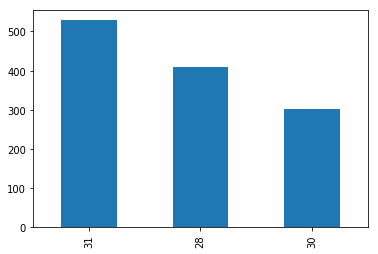

In [383]:
df_target_for_pics[df_target_for_pics['year'] == 2014]['days_in_month'].value_counts().plot(kind='bar')

In [349]:
df_target_for_pics['month/year']  = df_target_for_pics['month'].astype(str) + df_target_for_pics['year'].astype(str)

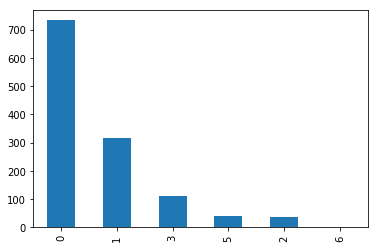

In [355]:
df_target_for_pics[df_target_for_pics['year'] == 2014]['day_of_week'].value_counts().plot(kind='bar')

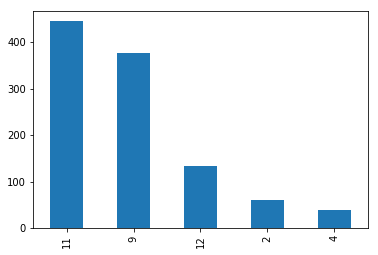

In [114]:
df_target_for_pics[df_target_for_pics['year'] == 2013]['month'].value_counts().plot(kind='bar')

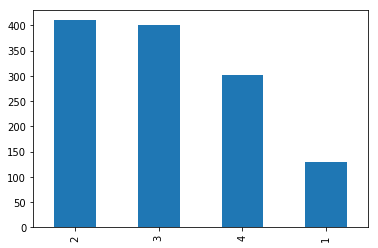

In [116]:
df_target_for_pics[df_target_for_pics['year'] == 2014]['month'].value_counts().plot(kind='bar')

In [127]:
# Dataframe with indices of visited websites in session
sites = ['site%s' % i for i in range(1, 11)]
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [10]:
# делаем список из топ10 сайтов, котрые Алиса посещает чаще всего! Это может быть очень жирным признаком
from collections import Counter
df_target = train_df[train_df['target']==1]
top10_list = []
for x,y in Counter(df_target[sites].values.flatten()).most_common(10):
    top10_list.append(x)


In [11]:
top10_list

[77, 80, 76, 29, 21, 81, 22, 879, 75, 82]

In [625]:
# последовательность с индексами
#sites_flatten = full_sites.values.flatten()

# искомая матрица
#full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                #sites_flatten,
                               #range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]


 Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [75]:
#добавляем в датафрейм новый столбец, который будет содержать количество, сколько раз в сессии встертились сайты из топ10 Алисы
sites = ['site%s' % i for i in range(1, 11)]
rows_list = []
for index, row in full_df.iterrows():
    counter = 0
    for site in sites:
        if row[site] in top10_list:
            counter= counter + 1
    row['top_count'] = counter
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time9,site10,time10,hour,month,morning,day,evening,weekend,top_count
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,1970-01-01 00:00:00,0,1970-01-01 00:00:00,8,1,1,0,0,1,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,1970-01-01 00:00:00,0,1970-01-01 00:00:00,8,1,1,0,0,1,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:17,946,2013-01-12 08:50:17,8,1,1,0,0,1,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:19,946,2013-01-12 08:50:20,8,1,1,0,0,1,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:22,947,2013-01-12 08:50:22,8,1,1,0,0,1,0


In [200]:
temp_full_df.shape

(336358, 27)

In [601]:
full_df_for_sparse = temp_full_df
for i in range(1, 11):
    full_df_for_sparse.drop('time%s' % i, axis = 1, inplace=True)
full_df_for_sparse.drop('top_count', axis = 1, inplace=True)  

In [52]:
full_df_for_sparse.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time8,site9,time9,site10,time10,hour,month,morning,sunday,sites_as_text
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,8,1,1,0,56 55 0 0 0 0 0 0 0 0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,8,1,1,0,56 55 56 55 0 0 0 0 0 0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,8,1,1,0,946 946 951 946 946 945 948 784 949 946
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,8,1,1,0,945 948 949 948 945 946 947 945 946 946
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,8,1,1,0,947 950 948 947 950 952 946 951 946 947


In [217]:
full_df_for_features['top_count'] = temp_full_df['top_count']

In [429]:
full_df_for_features = pd.DataFrame(full_df)

In [292]:
full_df_for_sparse = full_df

In [430]:
full_df_for_features.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [219]:
full_df_for_features = pd.get_dummies(full_df_for_features, drop_first = True, columns=['top_count'], prefix='is_in_top_10')

In [294]:
%%time
sites = ['site%s' % i for i in range(1, 11)]
full_df_for_sparse['sites_as_text'] = full_df_for_sparse[sites].astype(str).apply(' '.join,axis = 1)

Wall time: 23.7 s


In [317]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_features=100000).fit(full_df_for_sparse['sites_as_text'])
vectorized_sparsed_sites = vectorizer.transform(full_df_for_sparse['sites_as_text'])

Wall time: 48.3 s


In [668]:
#vectorizer = CountVectorizer(ngram_range=(1,1)) 
#vectorized_sparsed_sites = vectorizer.fit_transform(tmp_full_df['sites_as_text'])

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [431]:
#full_df_for_features.drop('top_count', axis = 1, inplace=True)
full_df_for_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 82797
Data columns (total 20 columns):
site1     336358 non-null int32
time1     336358 non-null datetime64[ns]
site2     336358 non-null int32
time2     336358 non-null datetime64[ns]
site3     336358 non-null int32
time3     336358 non-null datetime64[ns]
site4     336358 non-null int32
time4     336358 non-null datetime64[ns]
site5     336358 non-null int32
time5     336358 non-null datetime64[ns]
site6     336358 non-null int32
time6     336358 non-null datetime64[ns]
site7     336358 non-null int32
time7     336358 non-null datetime64[ns]
site8     336358 non-null int32
time8     336358 non-null datetime64[ns]
site9     336358 non-null int32
time9     336358 non-null datetime64[ns]
site10    336358 non-null int32
time10    336358 non-null datetime64[ns]
dtypes: datetime64[ns](10), int32(10)
memory usage: 41.1 MB


говорят хватит бинарных ранее утро, утро, вечер, обед и воскресенье

In [432]:
%%time

#for i in range(1, 11):
    #full_df_for_features['hour']           = full_df_for_features['time1'].apply(lambda time: pd.Timestamp(time).hour)
full_df_for_features['month']          = full_df_for_features['time1'].apply(lambda time: pd.Timestamp(time).month)
full_df_for_features['year']           = full_df_for_features['time1'].apply(lambda time: pd.Timestamp(time).year)
full_df_for_features['month/year']     = full_df_for_features['month'].astype(str) + full_df_for_features['year'].astype(str)
full_df_for_features['day_of_week']    = full_df_for_features['time1'].apply(lambda time: pd.Timestamp(time).dayofweek)
full_df_for_features['early_morning']        = full_df_for_features['time1'].apply(lambda time: 1 if (pd.Timestamp(time).hour >= 6) and (pd.Timestamp(time).hour <= 8) else 0)
full_df_for_features['morning']        = full_df_for_features['time1'].apply(lambda time: 1 if (pd.Timestamp(time).hour >= 9) and (pd.Timestamp(time).hour <= 11) else 0)
full_df_for_features['day']            = full_df_for_features['time1'].apply(lambda time: 1 if (pd.Timestamp(time).hour >= 12) and (pd.Timestamp(time).hour <= 18) else 0)
full_df_for_features['evening']        = full_df_for_features['time1'].apply(lambda time: 1 if (pd.Timestamp(time).hour >= 19) and (pd.Timestamp(time).hour <= 23) else 0)
full_df_for_features['night']          = full_df_for_features['time1'].apply(lambda time: 1 if (pd.Timestamp(time).hour >= 0) and (pd.Timestamp(time).hour <= 5) else 0)                                                                                
    #full_df_for_features['monday']         = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 0 else 0) 
    #full_df_for_features['tuesday']        = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 1 else 0) 
    #full_df_for_features['wedn']           = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 2 else 0) 
    #full_df_for_features['thurs']          = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 3 else 0) 
    #full_df_for_features['frid']           = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 4 else 0) 
    #full_df_for_features['saturnday']      = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 5 else 0) 
full_df_for_features['sunday']         = full_df_for_features['time1'].apply(lambda time: 1 if pd.Timestamp(time).dayofweek == 6 else 0) 
#full_df_for_features['weekend']        = full_df_for_features['time1'].apply(lambda time: 1 if (pd.Timestamp(time).dayofweek == 6) or (pd.Timestamp(time).dayofweek == 5) else 0) 

Wall time: 33.5 s


In [82]:
#full_df_for_features = pd.get_dummies(full_df_for_features, drop_first=True, columns=['hour'], prefix='hour')
#full_df_for_features = pd.get_dummies(full_df_for_features, drop_first=True, columns=['month'], prefix='month')

In [433]:
for i in range(1, 11):
    full_df_for_features.drop('time%s' % i, axis = 1, inplace=True)
    full_df_for_features.drop('site%s' % i, axis = 1, inplace=True)
full_df_for_features.drop('month', axis = 1, inplace=True)    
full_df_for_features.drop('year', axis = 1, inplace=True) 

In [434]:
full_df_for_features = pd.get_dummies(full_df_for_features, columns=['month/year'], prefix='month/year')
full_df_for_features = pd.get_dummies(full_df_for_features, columns=['day_of_week'], prefix='day_of_week')

In [398]:
new = pd.DataFrame(full_df_for_features)

In [399]:
full_df_for_features = pd.DataFrame(new)
full_df_for_features.drop('sunday', axis = 1, inplace=True)
full_df_for_features.head()

,morning,day,evening,night,month/year_102013,month/year_102014,month/year_112013,month/year_112014,month/year_12013,month/year_12014,...,month/year_82014,month/year_92013,month/year_92014,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
session_id,,,,,,,,,,,,,,,,,,,,,
21669,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
54843,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
77292,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
114021,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
146670,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [435]:
full_df_for_features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21669 to 82797
Data columns (total 37 columns):
early_morning        336358 non-null int64
morning              336358 non-null int64
day                  336358 non-null int64
evening              336358 non-null int64
night                336358 non-null int64
sunday               336358 non-null int64
month/year_102013    336358 non-null uint8
month/year_102014    336358 non-null uint8
month/year_112013    336358 non-null uint8
month/year_112014    336358 non-null uint8
month/year_12013     336358 non-null uint8
month/year_12014     336358 non-null uint8
month/year_122013    336358 non-null uint8
month/year_122014    336358 non-null uint8
month/year_22013     336358 non-null uint8
month/year_22014     336358 non-null uint8
month/year_32013     336358 non-null uint8
month/year_32014     336358 non-null uint8
month/year_42013     336358 non-null uint8
month/year_42014     336358 non-null uint8
month/year_52013     33635

In [712]:
#scaler = StandardScaler(copy=False, with_mean=False)
#full_df_for_features[['hour', 'month']] = pd.DataFrame(scaler.fit_transform(full_df_for_features[['hour', 'month']]))

In [57]:
#result_matrix = new_full_df.values

In [436]:
result_matrix = hstack([full_df_for_features.values, vectorized_sparsed_sites]).tocsr()

In [437]:
X_test = result_matrix[idx_split:, :]
X_train = result_matrix[:idx_split, :]
y_train = train_df['target']

In [438]:
X_test.shape

(82797, 100037)

In [439]:
X_train.shape

(253561, 100037)

Perform cross-validation with logistic regression.

In [440]:
%%time
tss = TimeSeriesSplit(n_splits=10)
#logit_cv2 = LogisticRegressionCV(n_jobs=-1, scoring ='roc_auc', cv=tss)
logit_cv2 = LogisticRegressionCV(Cs = [3], n_jobs=-1, scoring ='roc_auc', cv=tss)
logit_cv2.fit(X_train, y_train)

Wall time: 47.7 s


In [441]:
logit_cv2.scores_

{1: array([[ 0.8516829 ],
        [ 0.9015674 ],
        [ 0.86943481],
        [ 0.98293713],
        [ 0.85645857],
        [ 0.97294803],
        [ 0.936567  ],
        [ 0.96170748],
        [ 0.77891639],
        [ 0.97380226]])}

my best cv csore 0.98267878

In [442]:
y_pred = logit_cv2.predict_proba(X_test)[:, 1]
y_pred.shape

(82797,)

Make prediction for the test set and form a submission file.

In [443]:
test_pred = logit_cv2.predict_proba(X_test)[:, 1]

In [444]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [445]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")